In [104]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pickle
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LeakyReLU
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor,
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor, StackingRegressor,
                              VotingRegressor, ExtraTreesRegressor)
from sklearn.feature_selection import (SelectKBest, f_regression,
                                       mutual_info_regression)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, ConstantKernel, DotProduct,
                                              ExpSineSquared, Matern,
                                              RationalQuadratic)
from sklearn.linear_model import (ElasticNet, Lasso, LinearRegression,
                                  RANSACRegressor, Ridge)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor
from keras.wrappers.scikit_learn import KerasRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Function to calculate metrics of result prediction each model

In [3]:
def metrics(test, predict):
    MSE = mean_squared_error(test, predict)
    RMSE = np.sqrt(mean_squared_error(test, predict))
    MAE = mean_absolute_error(test, predict)
    R2_score = (r2_score(test, predict) * 100).round(3)
    print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, R2: {R2_score}")
    return [MSE, RMSE, MAE, R2_score]

### Function to visualize the received predicted values from actual ones

In [4]:
def lin_pred(predict, model):
    sns.set_palette("pastel")
    fig, ax = plt.subplots()
    ax.scatter(y_test, predict)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Actual price, UAH')
    ax.set_ylabel('Predicted price, UAH')
    plt.title(model)
    plt.show()

### Functions to find best hyper params for RandomForestRegressor, DesicionTreeRegressor, GradientBoostingRegressor, ExtraTreesRegressor

In [5]:
# DesicionTreeRegressor -- > False, RandomForestRegressor/ExtraTreesRegressor --> True 

def get_depth_leaf_tree(model, n_estimators = True):
    score_depth_leaf = []
    plot_score = []
    plot_depth = []
    for i in range(1, 20):
        for j in range(1, 10):
            if n_estimators:
                model_res = model(n_estimators=150, max_depth= i, min_samples_leaf= j)
            else:
                model_res = model(random_state=42, max_depth= i, min_samples_leaf= j)
            score = cross_val_score(model_res, x_train, y_train, cv = 5)
            score_depth_leaf.append((score.mean(), i, j))
            plot_depth.append(i)
            plot_score.append(score.mean())

    def take_score(elem: tuple):
        return elem[0]

    max_score = max(score_depth_leaf, key=take_score)
    best_score, best_depth, min_leaf = max_score
    drow(plot_depth, plot_score, best_depth, best_score, min_leaf, model)
    return max_score

In [74]:
# GradientBoostingRegressor

def get_depth_leaf_boost(model):
    score_depth_leaf = []
    plot_score = []
    plot_depth = []
    for i in range(1, 10):
        for j in range(1, 10):
            model_res = model(n_estimators=200, learning_rate=0.1,max_depth= i, min_samples_leaf= j)
            score = cross_val_score(model_res, x_train, y_train, cv = 10)
            score_depth_leaf.append((score.mean(), i, j))
            plot_depth.append(i)
            plot_score.append(score.mean())

    def take_score(elem: tuple):
        return elem[0]

    max_score = max(score_depth_leaf, key=take_score)
    best_score, best_depth, min_leaf = max_score

    drow(plot_depth, plot_score, best_depth, best_score, min_leaf, model)
    return max_score

###  Functions for visualization score values  hyper params models dependency

In [7]:
def drow(depth, score, best_depth, best_score, min_leaf, model):
    plt.title(f"{model}")
    plt.xlabel('depth')
    plt.ylabel('score')
    sns.set_palette("pastel")
    
    plt.plot(depth, score, label = 'score from depth')
    plt.scatter(best_depth, best_score, color = 'red', label = f'best score {best_score.round(2)}: min leaf {min_leaf}, max depth {best_depth}')
    
    plt.legend()
    plt.show()

In [8]:
def drow_compare_score(df):
    sns.set_palette("pastel")
    compare_r =  df.loc[compare_models.index == 'R2']
    compare_r.plot(kind='barh')

    plt.xlabel('Value, %')
    plt.title('Comparison of Model Performance Metrics, R score')

    plt.show()

In [9]:
def drow_compare_mae(df):
    sns.set_palette("pastel")
    compare_mse =  df.loc[compare_models.index == 'MAE']
    compare_mse.plot(kind='barh')

    plt.xlabel('MAE')
    plt.title('Comparison of Model Performance Metrics, MAE')
    
    plt.show()

## Explore the data

In [10]:
data = pd.read_csv('after_preprocessing.csv')
data.head()

district  status  balcony  area_kitchen  area_living  area  room  floor  \
0       1.0     2.0      1.0          11.0         27.0  52.0     1      9   
1       1.0     1.0      2.0           6.0         42.0  58.0     3      5   
2       5.0     2.0      1.0          18.0         15.0  44.0     1      2   
3       5.0     2.0      1.0          15.0         39.0  48.0     1      8   
4       2.0     3.0      1.0          15.0         39.0  50.0     1      8   

   price  age  
0  12500    3  
1   8500    1  
2  19300    2  
3  15000    3  
4  30800    3

In [11]:
data.describe().round()

district   status  balcony  area_kitchen  area_living     area  \
count   10971.0  10971.0  10971.0       10971.0      10971.0  10971.0   
mean        3.0      2.0      0.0          15.0         37.0     62.0   
std         1.0      1.0      1.0           4.0         11.0     23.0   
min         1.0      1.0      0.0           3.0          6.0      7.0   
25%         2.0      2.0      0.0          15.0         27.0     45.0   
50%         3.0      2.0      0.0          15.0         39.0     57.0   
75%         5.0      3.0      1.0          16.0         42.0     72.0   
max         6.0      3.0      4.0          83.0        175.0    180.0   

          room    floor    price      age  
count  10971.0  10971.0  10971.0  10971.0  
mean       2.0      5.0  19446.0      3.0  
std        1.0      3.0   8266.0      1.0  
min        1.0      0.0   7000.0      1.0  
25%        1.0      2.0  14000.0      3.0  
50%        2.0      4.0  17550.0      3.0  
75%        2.0      7.0  23100.0      3.0  
max        7.0     30.0  90000.0      3.0

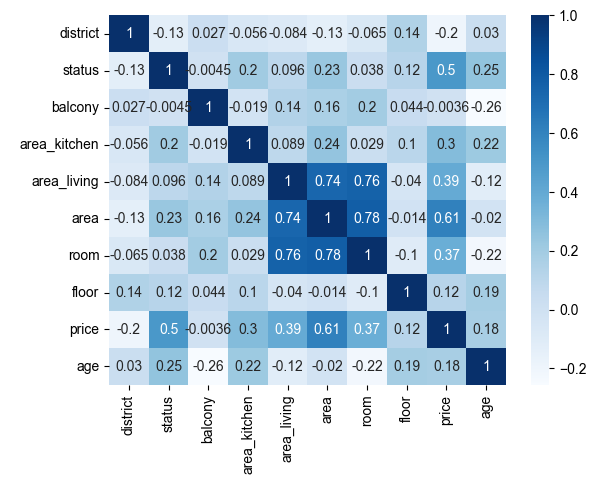

In [12]:
sns.heatmap(data.corr(), annot=True, cmap="Blues")
sns.set(rc={'figure.figsize':(15, 8)})

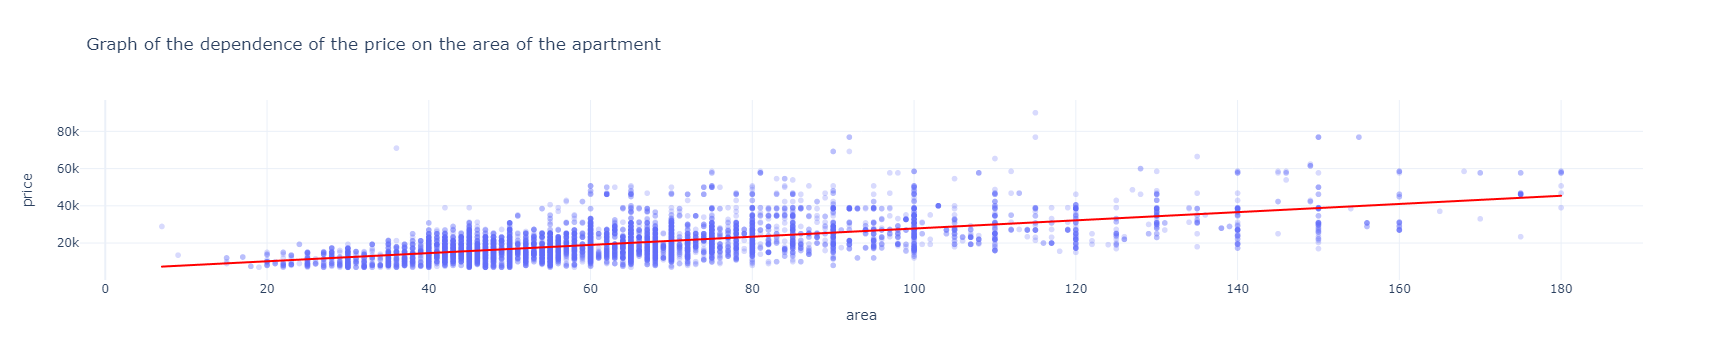

In [13]:
fig = px.scatter(data, x = 'area', y = 'price', opacity = 0.25, template = 'plotly_white', trendline='ols', trendline_color_override = 'red', title = 'Graph of the dependence of the price on the area of the apartment')
fig.show()

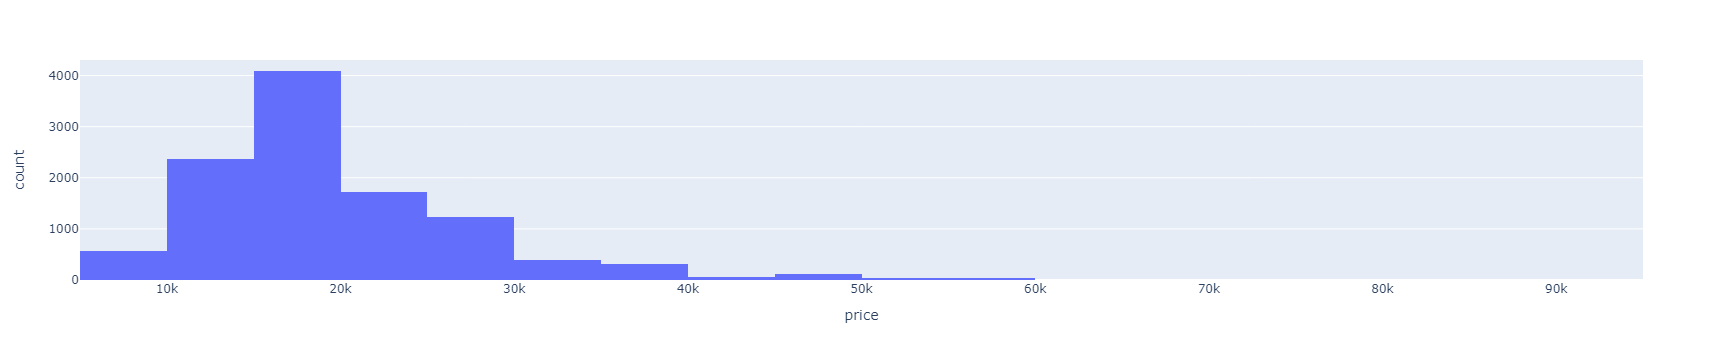

In [14]:
fig = px.histogram(data, x="price", nbins=40)
fig.show()

### Drop features which have high correlation between each other

In [15]:
X = data.drop(columns = ['price', 'area_living', 'room'], axis = 1)
y = data['price']

### Split data into train/test

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Building simple models

### *1. Linear Regression model*

In [17]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression()

In [18]:
predict_lin = linear_model.predict(x_test).round()

In [19]:
metrics(y_test, predict_lin)

MSE: 30465952.18405467, RMSE: 5519.597103417483, MAE: 3728.8765375854214, R2: 56.952


[30465952.18405467, 5519.597103417483, 3728.8765375854214, 56.952]

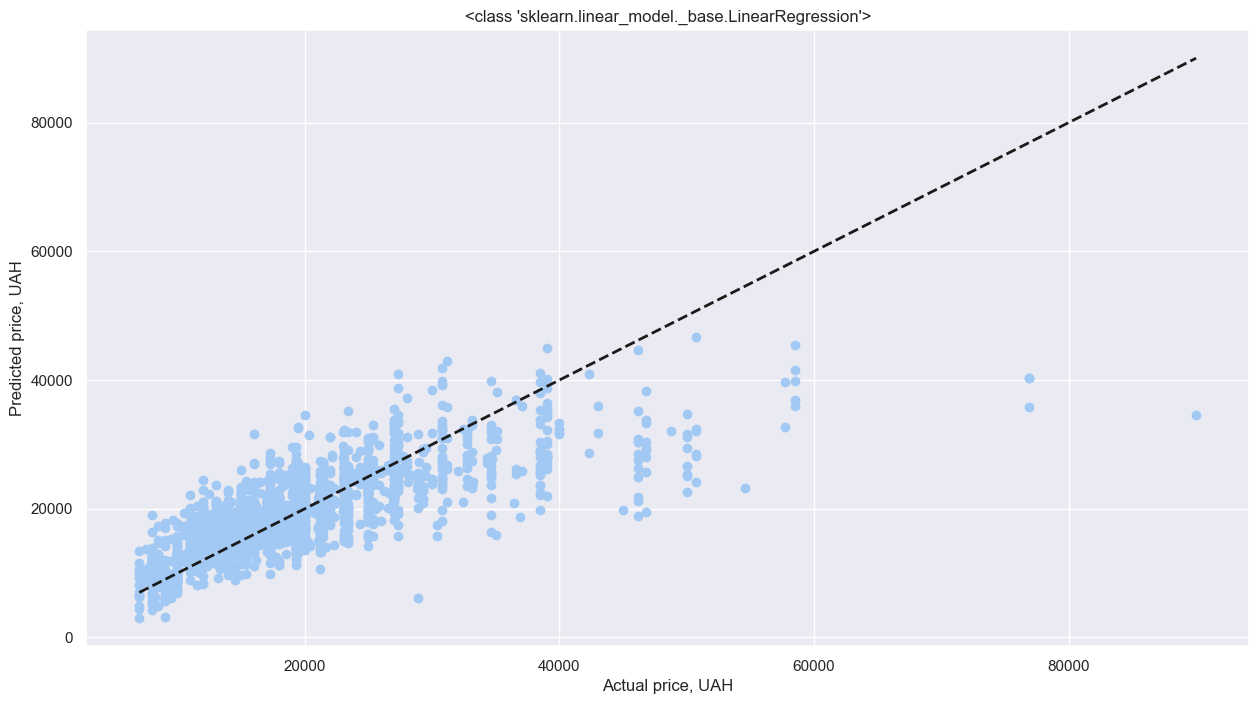

In [20]:
lin_pred(predict_lin, LinearRegression)

### We can see on the graph that the model cannot predict overpriced prices

<AxesSubplot: title={'center': 'Model Coefficients'}>

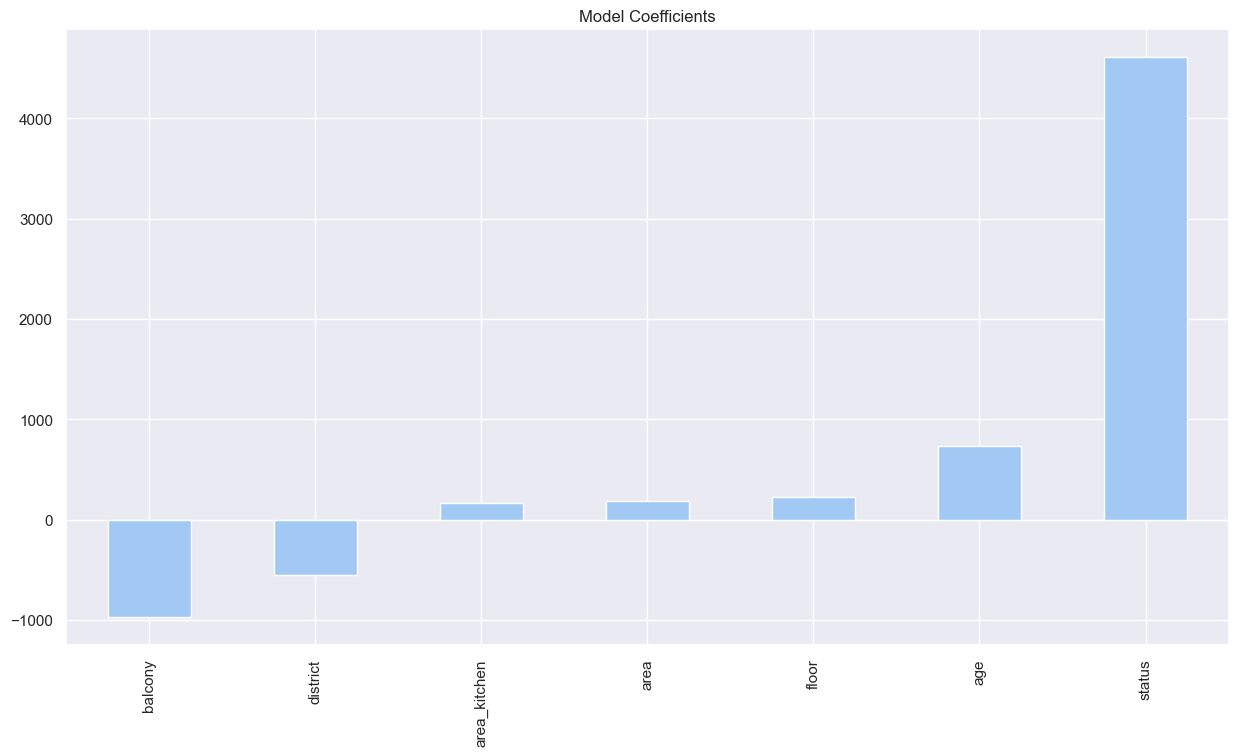

In [21]:
predictors = x_train.columns
sns.set_palette("pastel")
coef = pd.Series(linear_model.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

### *2. Polynomial Linear Regression model*

In [22]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [23]:
poly_model.fit(x_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('linear', LinearRegression(fit_intercept=False))])

In [24]:
poly_pred = poly_model.predict(x_test)

In [25]:
metrics(y_test, poly_pred)

MSE: 29127234.099680644, RMSE: 5396.965267599991, MAE: 3623.122908661735, R2: 58.843


[29127234.099680644, 5396.965267599991, 3623.122908661735, 58.843]

### The polynomial regression model outperformed the linear model by 2 percent

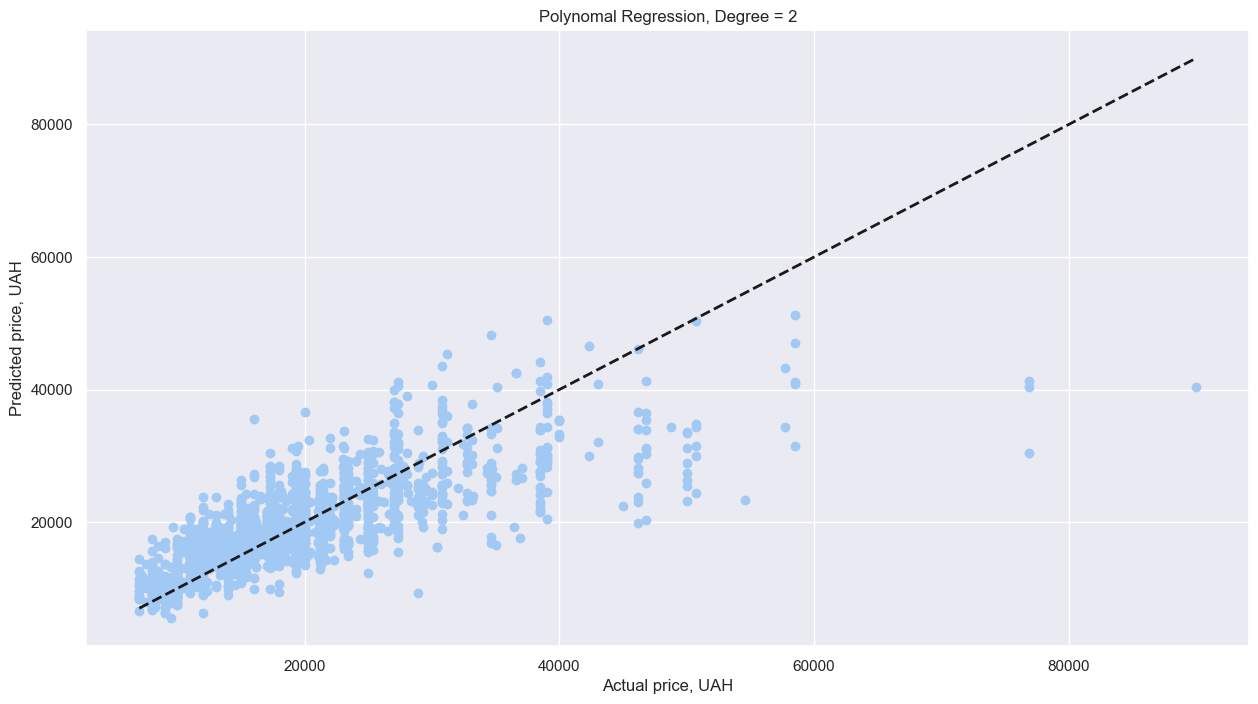

In [26]:
lin_pred(poly_pred, 'Polynomal Regression, Degree = 2')

##### We can try algorithm which useful for handling the outliers data

### *3. RANSACRegressor model*

In [27]:
ransac = RANSACRegressor(LinearRegression(),
		max_trials=200, 		
		min_samples=50, 		
		loss='squared_error', 	
		residual_threshold=10 	
		)

In [28]:
ransac.fit(x_train, y_train)

RANSACRegressor(estimator=LinearRegression(), loss='squared_error',
                max_trials=200, min_samples=50, residual_threshold=10)

In [29]:
ran_predict = ransac.predict(x_test)

In [30]:
metrics(y_test, ran_predict)

MSE: 34532823.58735975, RMSE: 5876.4635272721425, MAE: 3880.818200630043, R2: 51.205


[34532823.58735975, 5876.4635272721425, 3880.818200630043, 51.205]

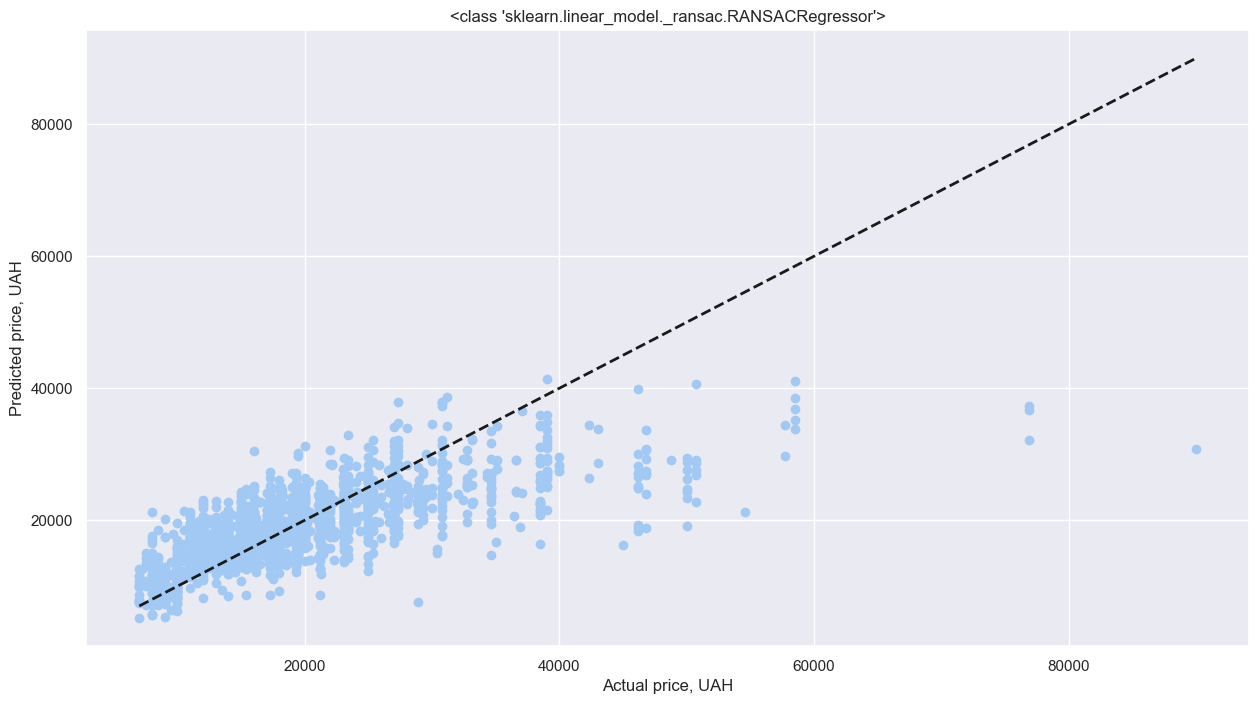

In [31]:
lin_pred(ran_predict, RANSACRegressor)

#### the obtained results are not better than the previous ones

#### Let's try to use different methods of regularization

### *4-6. Lasso, Ridge and ElasticNet regularization models*

In [32]:
ridgeReg = Ridge(alpha=1)
ridgeReg.fit(x_train, y_train)
pred_reg = ridgeReg.predict(x_test)
metrics(y_test, pred_reg)

MSE: 30465580.971232627, RMSE: 5519.563476510858, MAE: 3728.822666352007, R2: 56.952


[30465580.971232627, 5519.563476510858, 3728.822666352007, 56.952]

In [33]:
lassoReg = Lasso(alpha=2.3)
lassoReg.fit(x_train,y_train)
pred_lasso = lassoReg.predict(x_test)
metrics(y_test, pred_lasso)

MSE: 30463639.478434205, RMSE: 5519.387599945687, MAE: 3728.3710675892285, R2: 56.955


[30463639.478434205, 5519.387599945687, 3728.3710675892285, 56.955]

In [34]:
ENreg = ElasticNet(alpha=0.8, l1_ratio=1)
ENreg.fit(x_train,y_train)
pred_elastic = ENreg.predict(x_test)
metrics(y_test, pred_elastic)

MSE: 30465134.536528263, RMSE: 5519.523035238485, MAE: 3728.7002573819336, R2: 56.953


[30465134.536528263, 5519.523035238485, 3728.7002573819336, 56.953]

#### regularization of data didn't give positive results

### *7. K-Neighbors Regressor model*

#### Define a loop for choose best K by the elbow method

In [35]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values

In [36]:
min_rmse = min(rmse_val)
k_best = rmse_val.index(min_rmse)

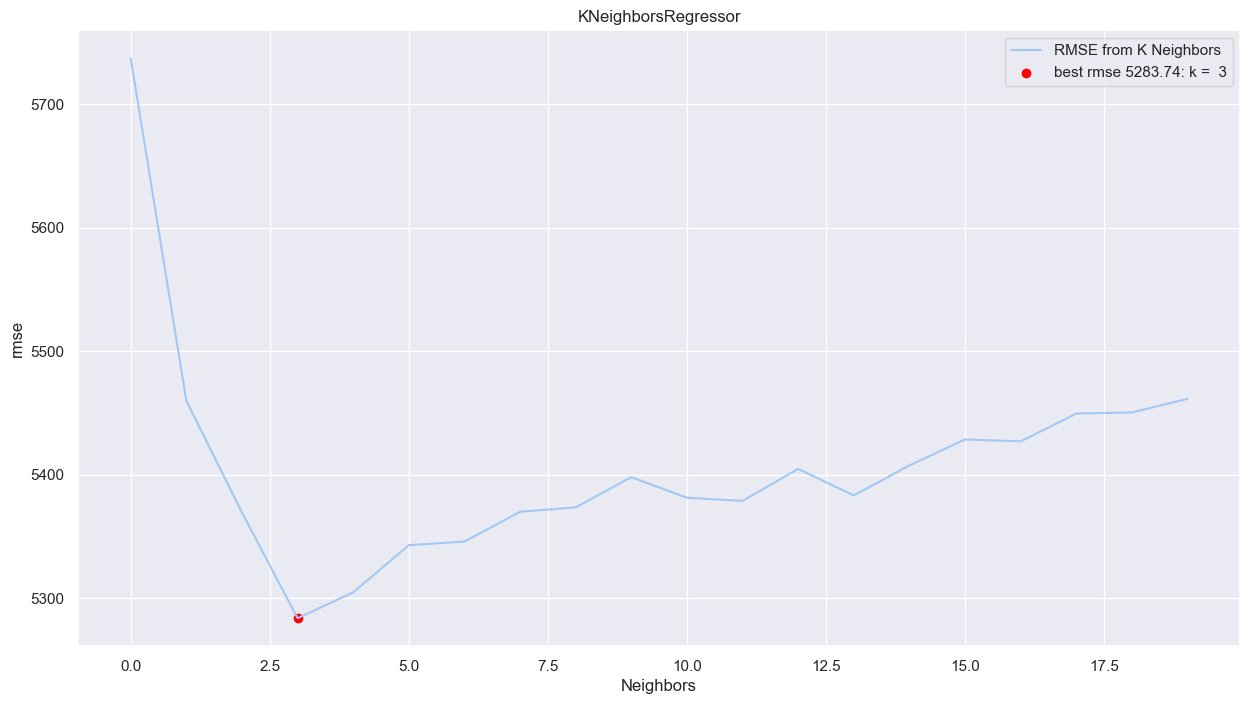

In [37]:
plt.title(f"KNeighborsRegressor")
plt.xlabel('Neighbors')
plt.ylabel('rmse')
sns.set_palette("icefire")
plt.plot(range(20), rmse_val, label = 'RMSE from K Neighbors')
plt.scatter(k_best, min_rmse, color = 'red', label = f'best rmse {min_rmse.round(2)}: k =  {k_best}')
plt.legend()
plt.show()

#### We can see on the graph that the best K neigbors is 3

In [38]:
k_neighb = KNeighborsRegressor(n_neighbors=3)

In [39]:
k_neighb =  k_neighb.fit(x_train, y_train)

In [40]:
k_neighb_pred = k_neighb.predict(x_test)

In [41]:
metrics(y_test, k_neighb_pred)

MSE: 28830112.690863073, RMSE: 5369.367997340383, MAE: 3415.1374335611235, R2: 59.263


[28830112.690863073, 5369.367997340383, 3415.1374335611235, 59.263]

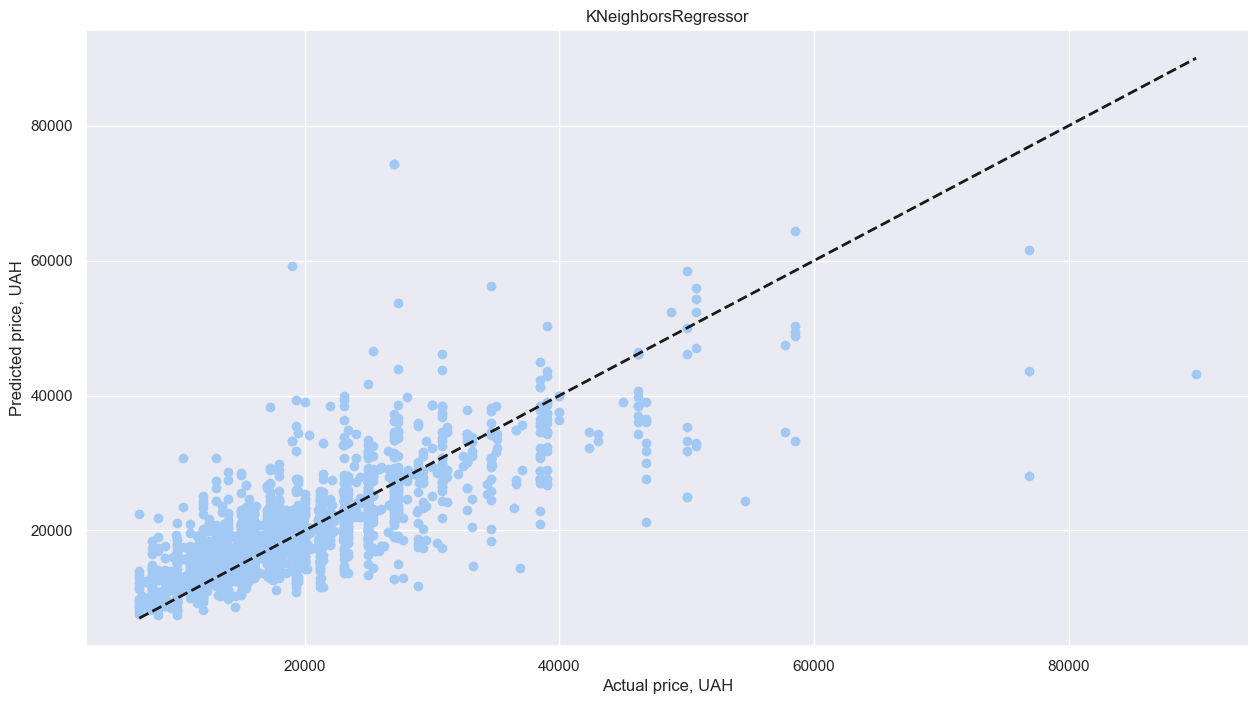

In [42]:
lin_pred(k_neighb_pred, 'KNeighborsRegressor')

#### Is the best result at the moment, KNeighborsRegressor could predict values which starts from 40000

### *9. Decision Tree Regressor model*

#### Call above defined function for choosing the best hyperparameters

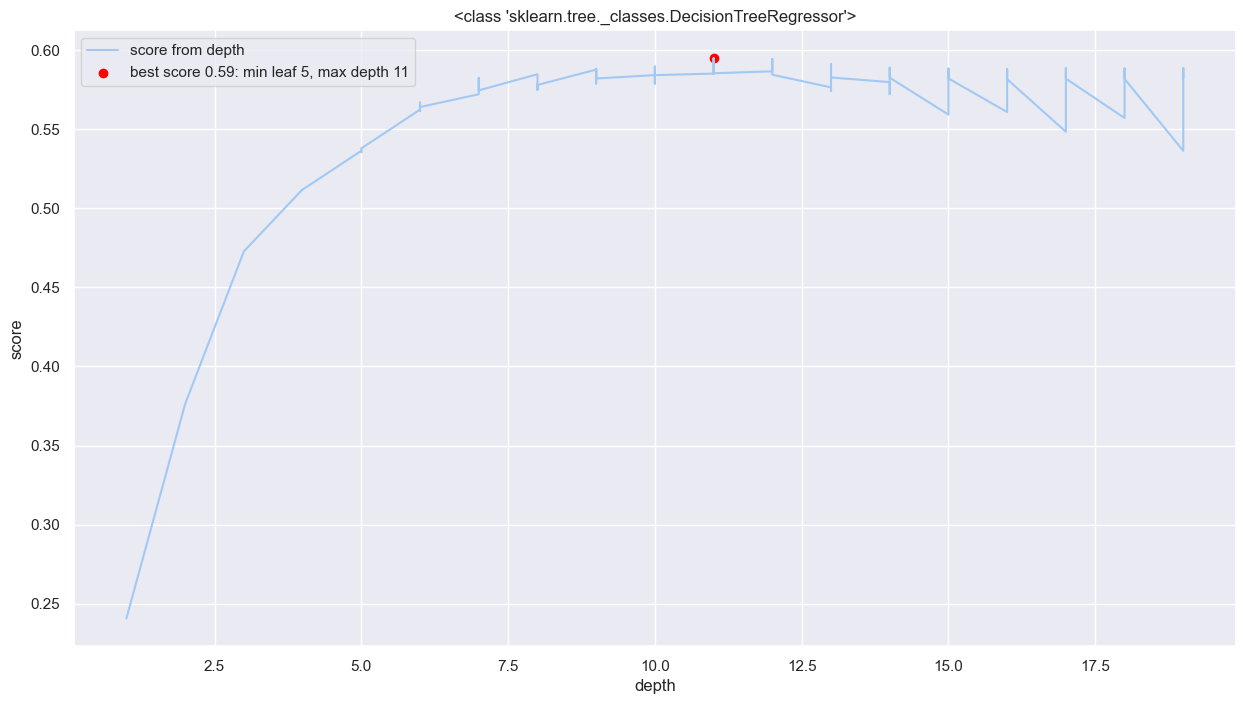

(0.5949140502533332, 11, 5)

In [43]:
get_depth_leaf_tree(DecisionTreeRegressor, n_estimators=False)

In [44]:
tree_model = DecisionTreeRegressor(max_depth=11, min_samples_leaf=5, random_state=42)

In [45]:
tree_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=11, min_samples_leaf=5, random_state=42)

In [46]:
tree_predict = tree_model.predict(x_test)

In [47]:
# dot_data = export_graphviz(tree_model, out_file=None) 
# graph = graphviz.Source(dot_data)
# graph

In [48]:
metrics(y_test, tree_predict)

MSE: 26752472.517339636, RMSE: 5172.279238144402, MAE: 3428.593630067687, R2: 62.199


[26752472.517339636, 5172.279238144402, 3428.593630067687, 62.199]

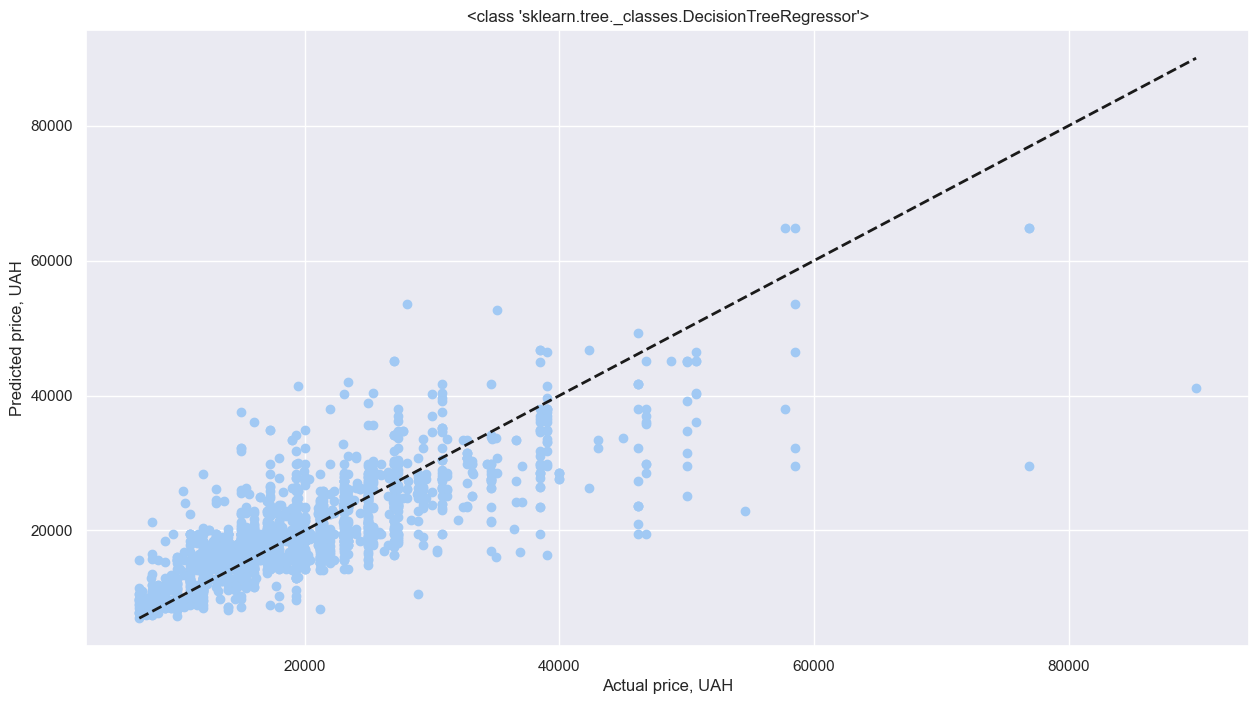

In [49]:
lin_pred(tree_predict, DecisionTreeRegressor)

#### For the moment is the best result, tree model predict better price, so this is a good sign for building ensembles with usage RandomForestRegressor or ExtraTreeRegressor

### *10. Keras API of TensorFlow*

In [50]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(10000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [51]:
model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=128, epochs=400)

Epoch 1/400
69/69 [==============================] - 17s 227ms/step - loss: 95491064.0000 - val_loss: 38348572.0000
Epoch 2/400
69/69 [==============================] - 15s 224ms/step - loss: 40320096.0000 - val_loss: 37567256.0000
Epoch 3/400
69/69 [==============================] - 16s 230ms/step - loss: 38911088.0000 - val_loss: 39594492.0000
Epoch 4/400
69/69 [==============================] - 17s 241ms/step - loss: 36677656.0000 - val_loss: 32996816.0000
Epoch 5/400
69/69 [==============================] - 15s 222ms/step - loss: 34962980.0000 - val_loss: 31947864.0000
Epoch 6/400
69/69 [==============================] - 15s 220ms/step - loss: 34040280.0000 - val_loss: 31478694.0000
Epoch 7/400
69/69 [==============================] - 17s 239ms/step - loss: 33844716.0000 - val_loss: 41126780.0000
Epoch 8/400
69/69 [==============================] - 17s 243ms/step - loss: 35392576.0000 - val_loss: 31570838.0000
Epoch 9/400
69/69 [==============================] - 16s 233ms/step - lo

In [52]:
kers = model.predict(x_test).round()

69/69 [==============================] - 1s 15ms/step


In [53]:
kers = kers.flatten().tolist()

In [54]:
metrics(y_test, kers)

MSE: 25659794.908428244, RMSE: 5065.549813043816, MAE: 3376.615945330296, R2: 63.743


[25659794.908428244, 5065.549813043816, 3376.615945330296, 63.743]

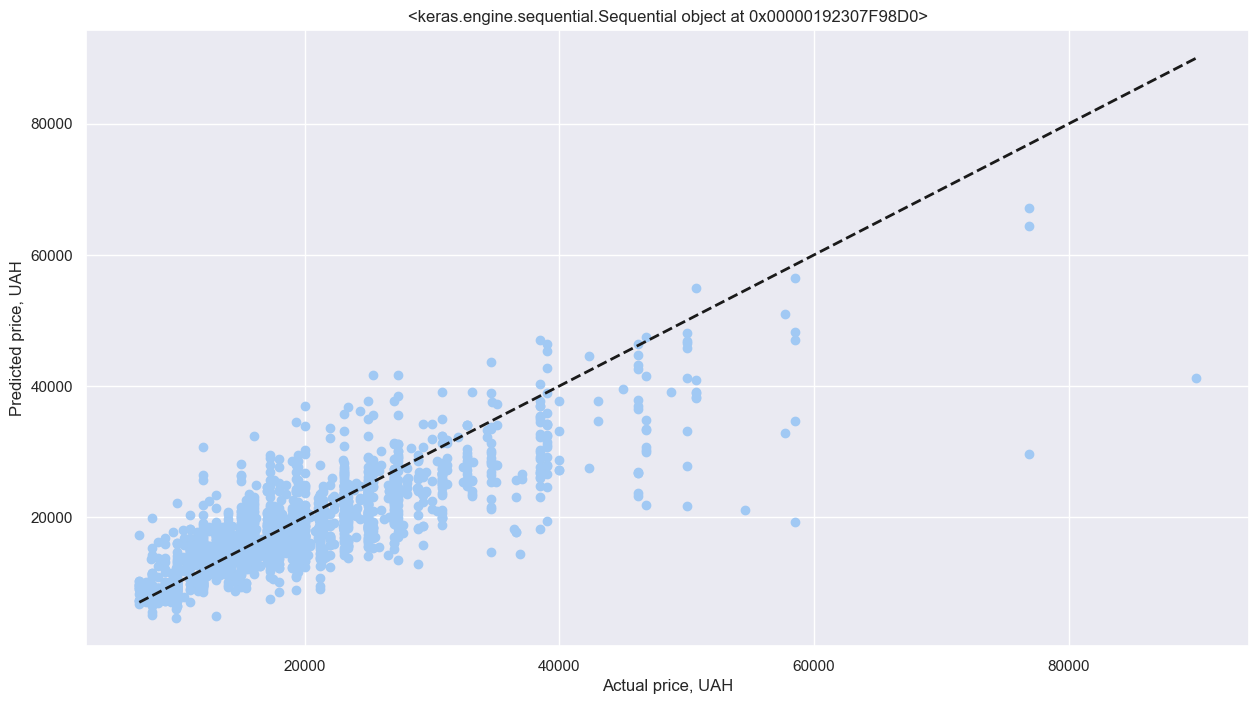

In [55]:
lin_pred(kers, model)

In [56]:
compare_models = pd.DataFrame({'test' : y_test, 'keras' : kers, 'tree' : tree_predict.round() , 'linear' : predict_lin, 'poly' : poly_pred.round(), 'k_neigh' : k_neighb_pred.round(), 'elastic' : pred_elastic.round()})
compare_models.head(10)

test    keras     tree   linear     poly  k_neigh  elastic
7434   15000  14236.0  17052.0  21007.0  19694.0  15667.0  21005.0
10428  15400  15784.0  15691.0  15402.0  15484.0  13467.0  15401.0
8617   19500  12892.0  15153.0  17850.0  16882.0  12333.0  17853.0
360    30800  25620.0  27689.0  32249.0  32213.0  21800.0  32249.0
6814   46800  34857.0  35817.0  29381.0  30978.0  36467.0  29378.0
4217   15400  14474.0  15837.0  18042.0  17384.0  18500.0  18041.0
3060   14000  18096.0  16129.0  15208.0  12785.0  15067.0  15206.0
1768   15000  20021.0  18791.0  18737.0  18083.0  17667.0  18739.0
9335   27000  19285.0  20076.0  19929.0  19130.0  25433.0  19926.0
9427   20000  17258.0  20200.0  24508.0  24462.0  14600.0  24506.0

In [57]:
compare_models = pd.DataFrame({'keras' : metrics(y_test, kers), 'tree' : metrics(y_test, tree_predict) , 'linear' : metrics(y_test, predict_lin), 'poly' : metrics(y_test, poly_pred), 'k_neigh' : metrics(y_test, k_neighb_pred),  'elastic' : metrics(y_test, pred_elastic) })
compare_models.index = ['MSE', 'RMSE', 'MAE', 'R2']
compare_models.round()

MSE: 25659794.908428244, RMSE: 5065.549813043816, MAE: 3376.615945330296, R2: 63.743
MSE: 26752472.517339636, RMSE: 5172.279238144402, MAE: 3428.593630067687, R2: 62.199
MSE: 30465952.18405467, RMSE: 5519.597103417483, MAE: 3728.8765375854214, R2: 56.952
MSE: 29127234.099680644, RMSE: 5396.965267599991, MAE: 3623.122908661735, R2: 58.843
MSE: 28830112.690863073, RMSE: 5369.367997340383, MAE: 3415.1374335611235, R2: 59.263
MSE: 30465134.536528263, RMSE: 5519.523035238485, MAE: 3728.7002573819336, R2: 56.953


keras        tree      linear        poly     k_neigh     elastic
MSE   25659795.0  26752473.0  30465952.0  29127234.0  28830113.0  30465135.0
RMSE      5066.0      5172.0      5520.0      5397.0      5369.0      5520.0
MAE       3377.0      3429.0      3729.0      3623.0      3415.0      3729.0
R2          64.0        62.0        57.0        59.0        59.0        57.0

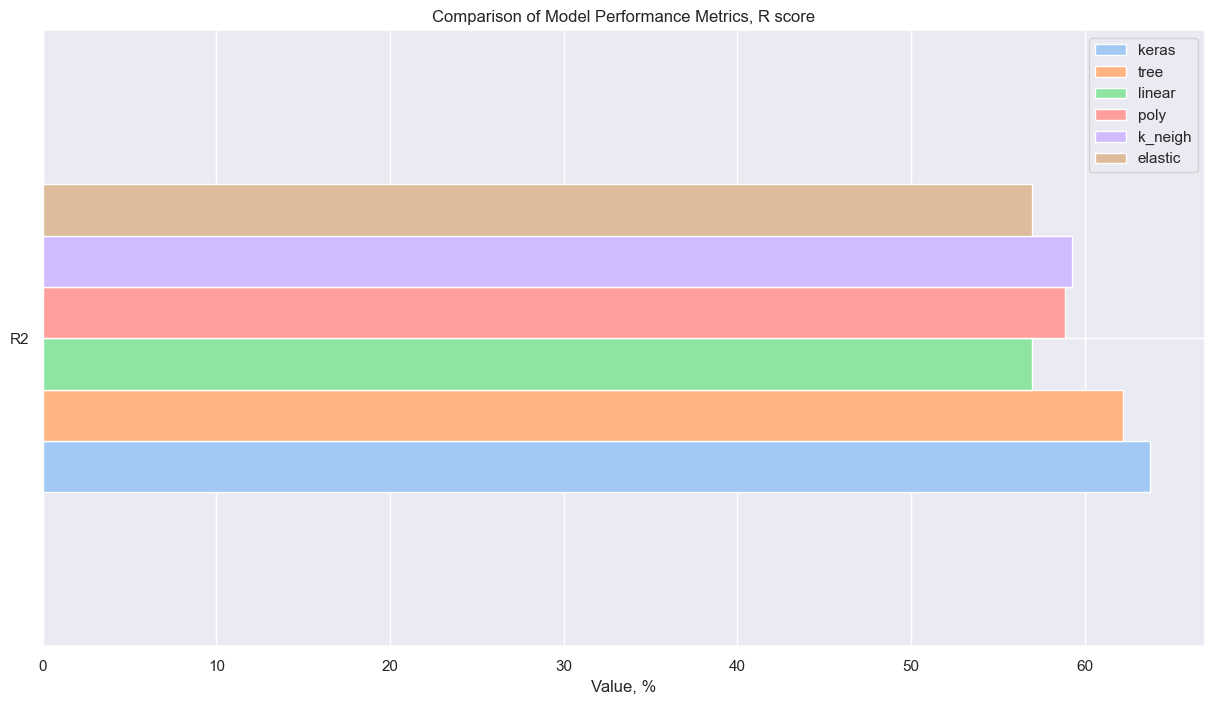

In [58]:
drow_compare_score(compare_models)

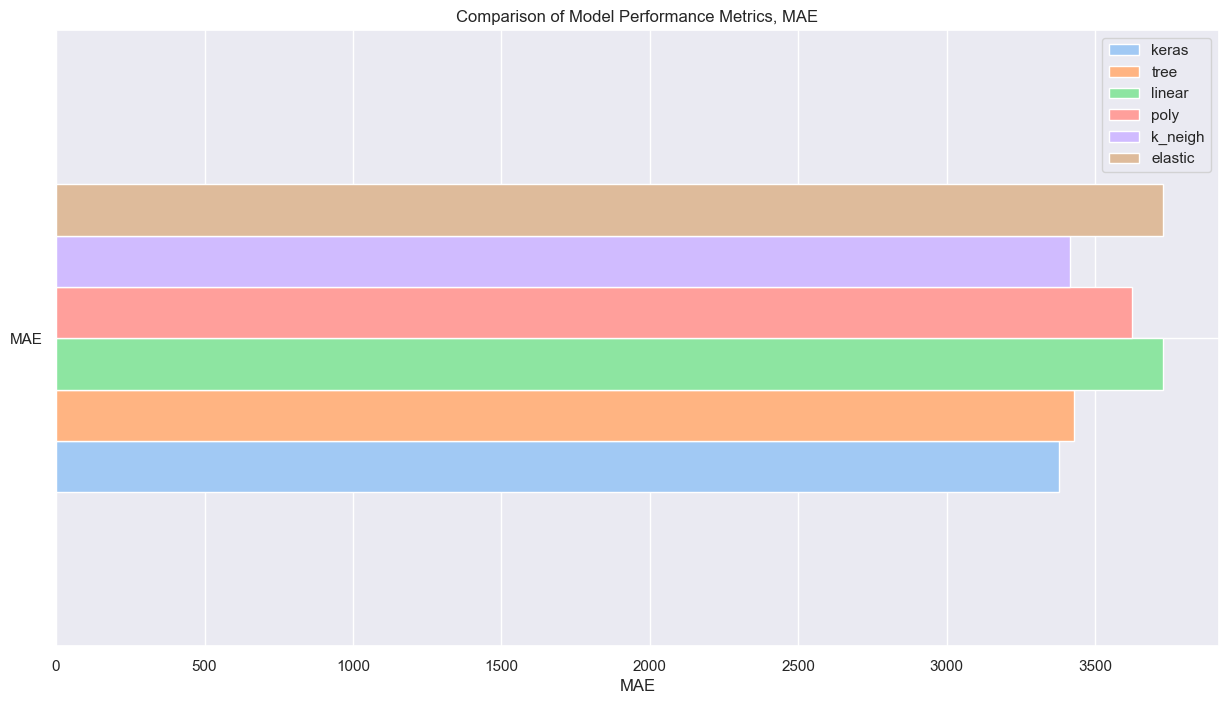

In [59]:
drow_compare_mae(compare_models)

#### The comparative graphs show that the Keras model gives the best results, followed by the Decision Tree

## Вuilding ensembles and more complex machine learning models

### *1. Random Forest Regressor*

#### Call above defined function for choosing the best hyperparameters

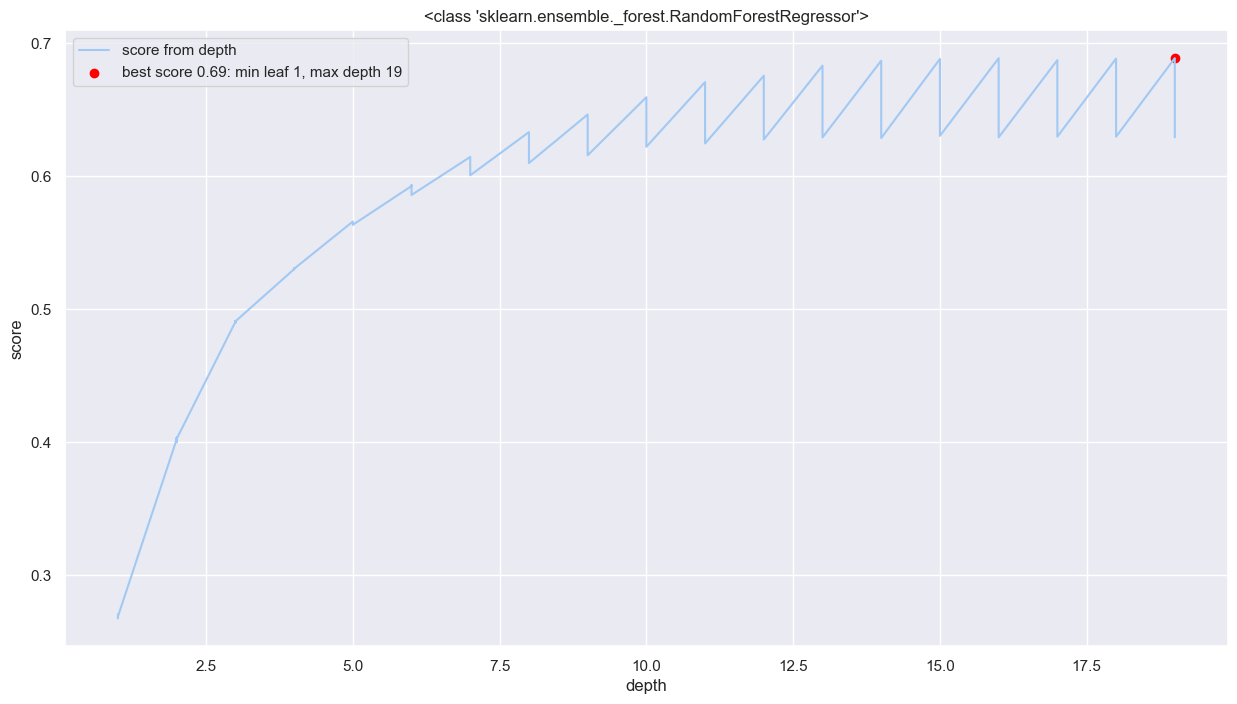

(0.6888191431596159, 19, 1)

In [60]:
get_depth_leaf_tree(RandomForestRegressor, n_estimators=True)

#### We can see on the graph the score value plateaued from 14 depth, so we will choose max depth 14

In [61]:
forest = RandomForestRegressor(random_state=42, max_depth=14, min_samples_leaf=1, n_estimators=200)

In [62]:
forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=14, n_estimators=200, random_state=42)

In [63]:
forest_predict = forest.predict(x_test)

In [64]:
metrics(y_test, forest_predict)

MSE: 20800836.01813351, RMSE: 4560.793354026634, MAE: 2963.1004401327605, R2: 70.608


[20800836.01813351, 4560.793354026634, 2963.1004401327605, 70.608]

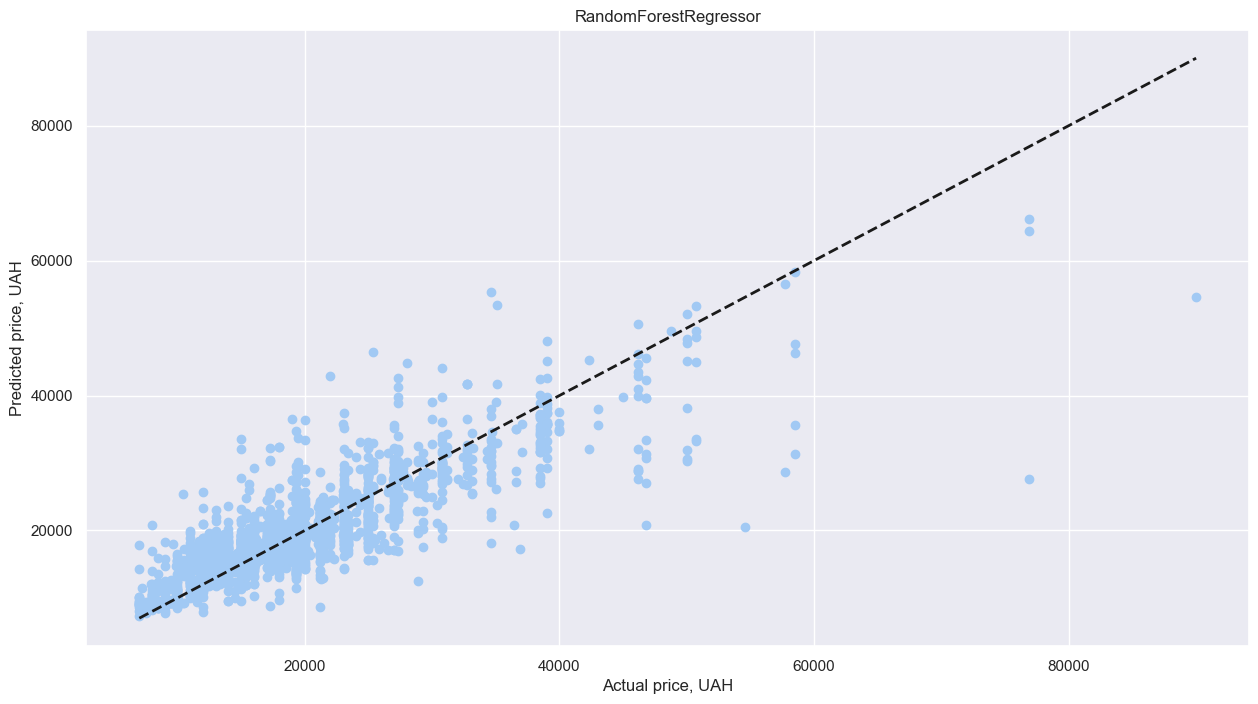

In [65]:
lin_pred(forest_predict, 'RandomForestRegressor')

#### The hypothesis that the Decision Tree can predict a higher price more precisely was confirmed and we see it on the graph

### *2. Extra Trees Regressor*

#### Call above defined function for choosing the best hyperparameters

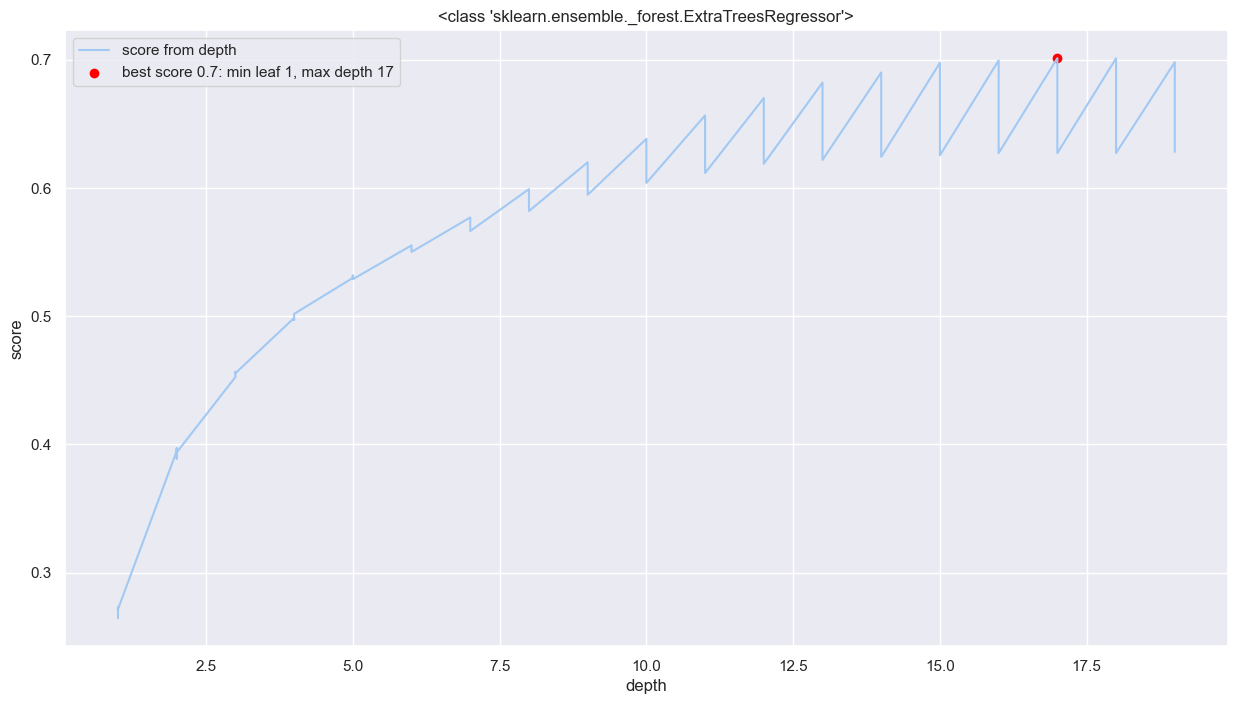

(0.7010569028858099, 17, 1)

In [66]:
get_depth_leaf_tree(ExtraTreesRegressor, n_estimators=True)

#### We have similar situation like a Random Forest Regressor, so we will choose max depth 14

In [67]:
extra_tree = ExtraTreesRegressor(random_state=42, max_depth=14, min_samples_leaf=1, n_estimators=200, criterion="squared_error")

In [68]:
extra_tree.fit(x_train, y_train)

ExtraTreesRegressor(max_depth=14, n_estimators=200, random_state=42)

In [69]:
extra_tree_pred = extra_tree.predict(x_test)

In [70]:
metrics(y_test, extra_tree_pred)

MSE: 19663228.853053093, RMSE: 4434.323945434421, MAE: 2868.8775349815173, R2: 72.216


[19663228.853053093, 4434.323945434421, 2868.8775349815173, 72.216]

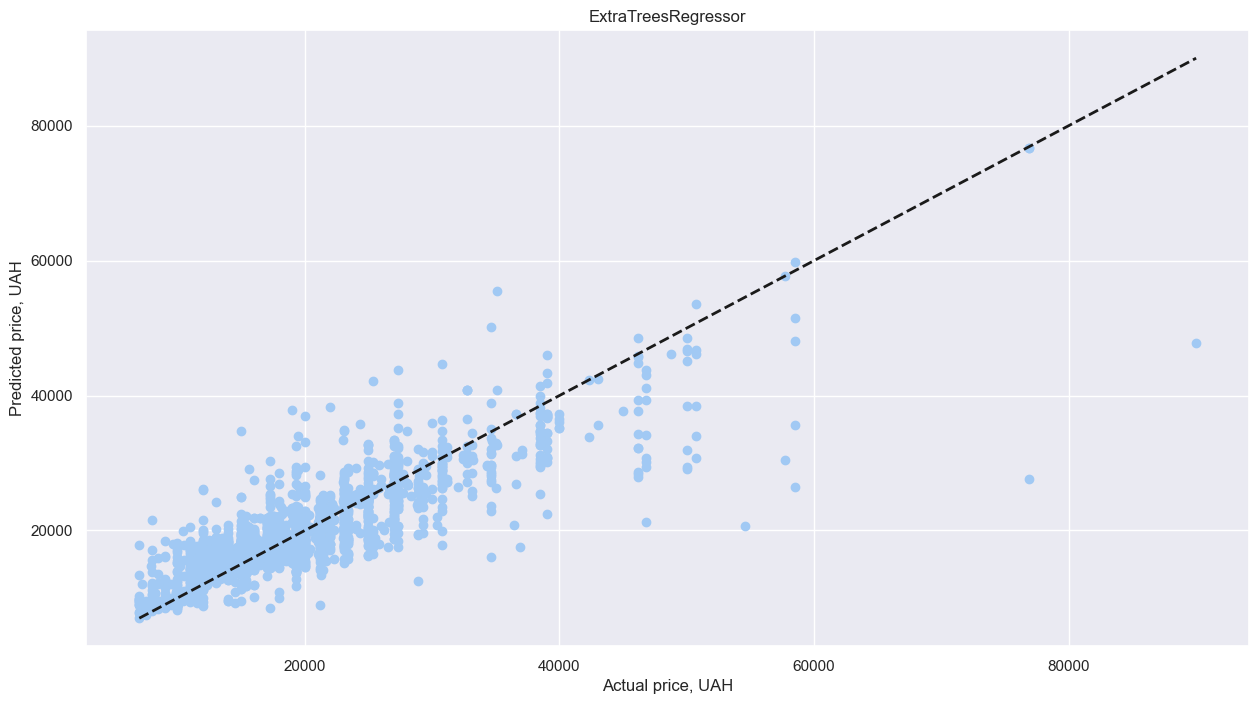

In [71]:
lin_pred(extra_tree_pred, 'ExtraTreesRegressor')

#### Model Extra Trees Regressor works the most correct than other models

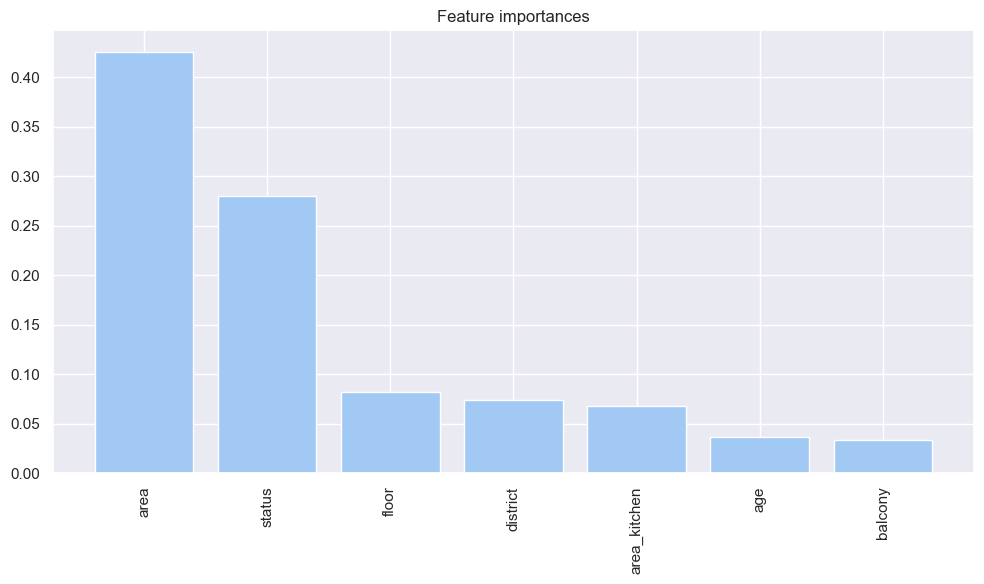

In [72]:
sns.set_palette("pastel")
feat_importances = extra_tree.feature_importances_
feat_names = x_train.columns
indices = np.argsort(feat_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feat_importances[indices])
plt.xticks(range(X.shape[1]), feat_names[indices], rotation=90)
plt.tight_layout()
plt.show()

#### If we return to previos bar plot with feature importants we can see big differance between models

### *3. Gradient Boosting Regressor*

#### Call above defined function for choosing the best hyperparameters

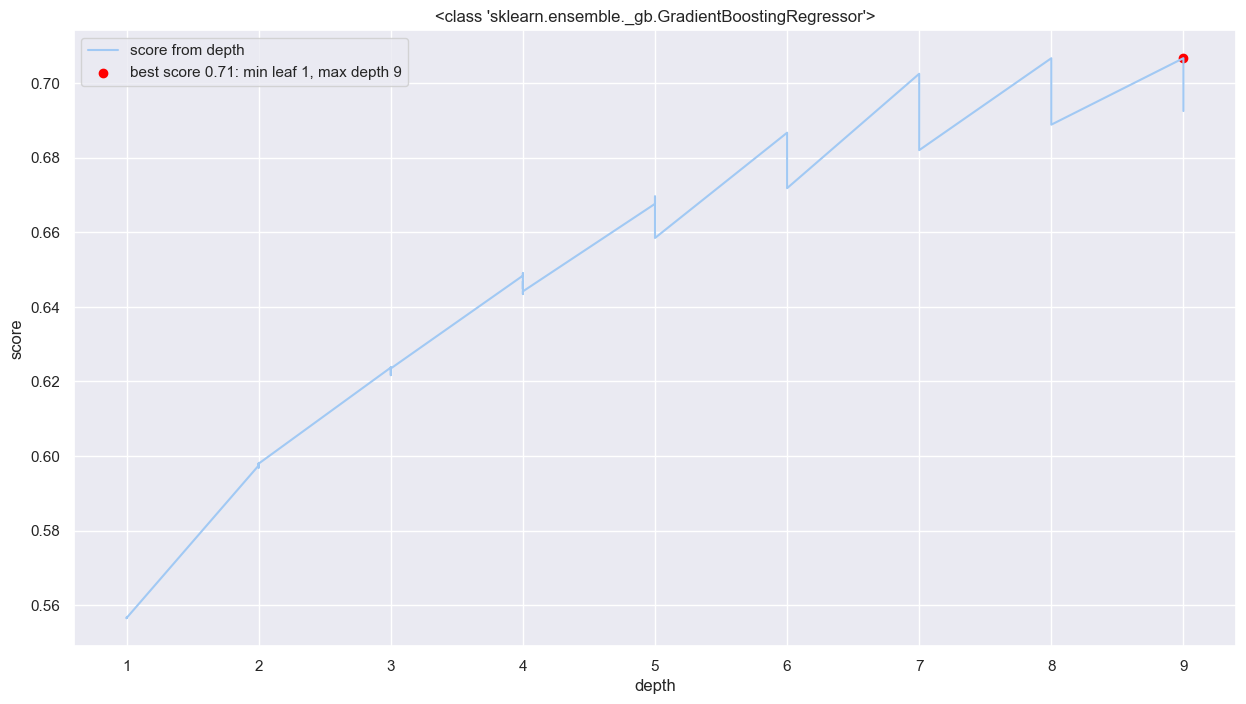

(0.7066706379654997, 9, 1)

In [75]:
get_depth_leaf_boost(GradientBoostingRegressor)

In [76]:
boost = GradientBoostingRegressor(max_depth=8, min_samples_leaf=1, random_state=42, n_estimators=500)

In [77]:
boost.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=8, n_estimators=500, random_state=42)

In [78]:
boost_pred = boost.predict(x_test)

In [79]:
metrics(y_test, boost_pred)

MSE: 20922902.216215353, RMSE: 4574.155902045245, MAE: 2792.254624666856, R2: 70.436


[20922902.216215353, 4574.155902045245, 2792.254624666856, 70.436]

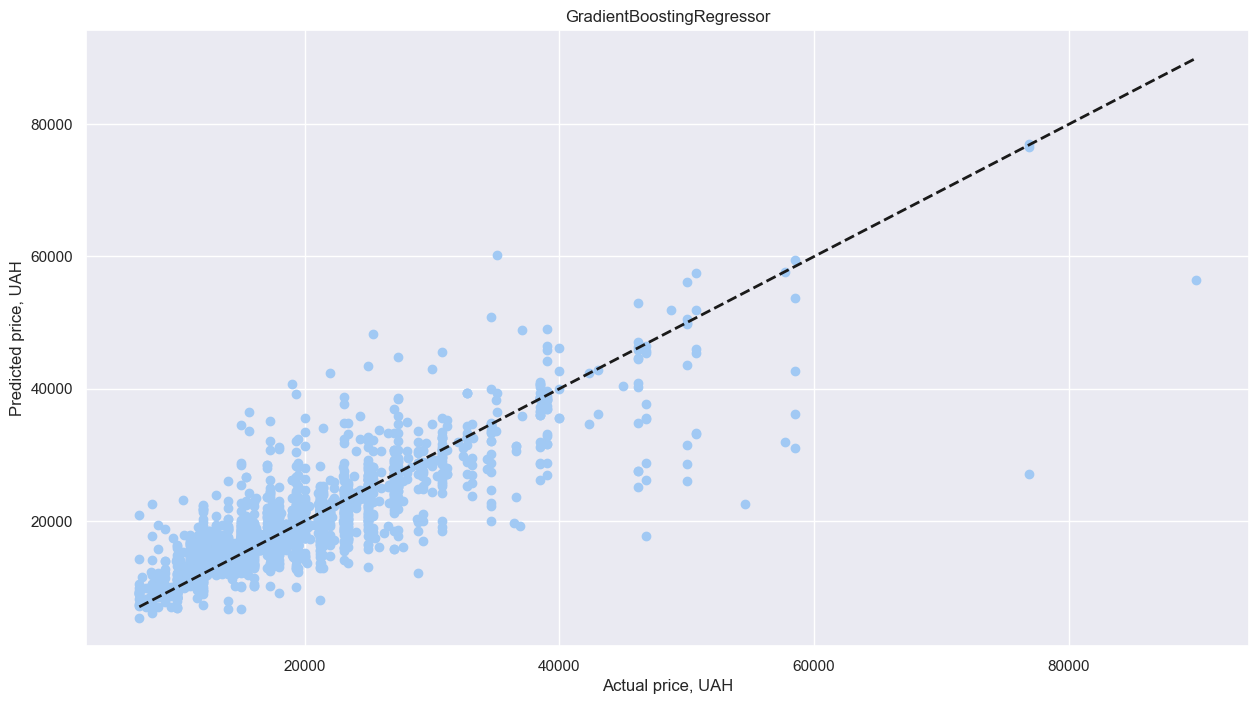

In [80]:
lin_pred(boost_pred, 'GradientBoostingRegressor')

### *4. Ensemble Voting Regressor*

In [92]:
reg = VotingRegressor(estimators=[('rf', forest), ('gb', boost), ('k_neigh', bagg)])

In [93]:
reg.fit(x_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=14,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('gb',
                             GradientBoostingRegressor(max_depth=8,
                                                       n_estimators=500,
                                                       random_state=42)),
                            ('k_neigh',
                             BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=3),
                                              n_estimators=50,
                                              random_state=42))])

In [94]:
voit = reg.predict(x_test)

In [95]:
metrics(y_test, voit)

MSE: 19668316.15587117, RMSE: 4434.8975361186385, MAE: 2847.7927915855416, R2: 72.209


[19668316.15587117, 4434.8975361186385, 2847.7927915855416, 72.209]

### *5. Ensemble Stacking Regressor*

In [85]:
st_reg = StackingRegressor(estimators=[('extra_tree', extra_tree), 
                                       ('GBoost', boost)],
                           final_estimator = poly_model)

In [86]:
st_reg.fit(x_train, y_train)

StackingRegressor(estimators=[('extra_tree',
                               ExtraTreesRegressor(max_depth=14,
                                                   n_estimators=200,
                                                   random_state=42)),
                              ('GBoost',
                               GradientBoostingRegressor(max_depth=8,
                                                         n_estimators=500,
                                                         random_state=42))],
                  final_estimator=Pipeline(steps=[('poly',
                                                   PolynomialFeatures()),
                                                  ('linear',
                                                   LinearRegression(fit_intercept=False))]))

In [87]:
predict_stack = st_reg.predict(x_test)

In [88]:
metrics(y_test, predict_stack)

MSE: 18980887.662231527, RMSE: 4356.70605644121, MAE: 2742.6687669494163, R2: 73.18


[18980887.662231527, 4356.70605644121, 2742.6687669494163, 73.18]

### *6. Ensemble Bagging Regressor*

In [89]:
bagg = BaggingRegressor(estimator=k_neighb, random_state=42, n_estimators=50)
bagg.fit(x_train, y_train)

BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=3), n_estimators=50,
                 random_state=42)

In [90]:
bagg_res = bagg.predict(x_test)

In [91]:
metrics(y_test, bagg_res)

MSE: 25566841.8482007, RMSE: 5056.366466960311, MAE: 3285.0619468488985, R2: 63.874


[25566841.8482007, 5056.366466960311, 3285.0619468488985, 63.874]

### *7. AdaBoost Regressor*

In [96]:
ada_model = AdaBoostRegressor(estimator=extra_tree, n_estimators=150, random_state=42)

In [97]:
ada_model.fit(x_train, y_train)

AdaBoostRegressor(estimator=ExtraTreesRegressor(max_depth=14, n_estimators=200,
                                                random_state=42),
                  n_estimators=150, random_state=42)

In [98]:
ada_predict = ada_model.predict(x_test)

In [99]:
metrics(y_test, ada_predict)

MSE: 20730615.717886396, RMSE: 4553.088591043051, MAE: 3020.6297015164305, R2: 70.708


[20730615.717886396, 4553.088591043051, 3020.6297015164305, 70.708]

## Metrics models

In [100]:
compare_ensamble = pd.DataFrame({
                                'forest' : metrics(y_test, forest_predict),
                                'ada_boost' : metrics(y_test, ada_predict),
                                'bagging' : metrics(y_test, bagg_res),
                                'extra_tree' : metrics(y_test, extra_tree_pred),
                                'stacking' : metrics(y_test, predict_stack),
                                'voting' : metrics(y_test, voit),
                                'gradientboost' : metrics(y_test, boost_pred)
})
compare_ensamble.index = ['MSE', 'RMSE', 'MAE', 'R2']

MSE: 20800836.01813351, RMSE: 4560.793354026634, MAE: 2963.1004401327605, R2: 70.608
MSE: 20730615.717886396, RMSE: 4553.088591043051, MAE: 3020.6297015164305, R2: 70.708
MSE: 25566841.8482007, RMSE: 5056.366466960311, MAE: 3285.0619468488985, R2: 63.874
MSE: 19663228.853053093, RMSE: 4434.323945434421, MAE: 2868.8775349815173, R2: 72.216
MSE: 18980887.662231527, RMSE: 4356.70605644121, MAE: 2742.6687669494163, R2: 73.18
MSE: 19668316.15587117, RMSE: 4434.8975361186385, MAE: 2847.7927915855416, R2: 72.209
MSE: 20922902.216215353, RMSE: 4574.155902045245, MAE: 2792.254624666856, R2: 70.436


In [101]:
compare_ensamble.round()

forest   ada_boost     bagging  extra_tree    stacking      voting  \
MSE   20800836.0  20730616.0  25566842.0  19663229.0  18980888.0  19668316.0   
RMSE      4561.0      4553.0      5056.0      4434.0      4357.0      4435.0   
MAE       2963.0      3021.0      3285.0      2869.0      2743.0      2848.0   
R2          71.0        71.0        64.0        72.0        73.0        72.0   

      gradientboost  
MSE      20922902.0  
RMSE         4574.0  
MAE          2792.0  
R2             70.0

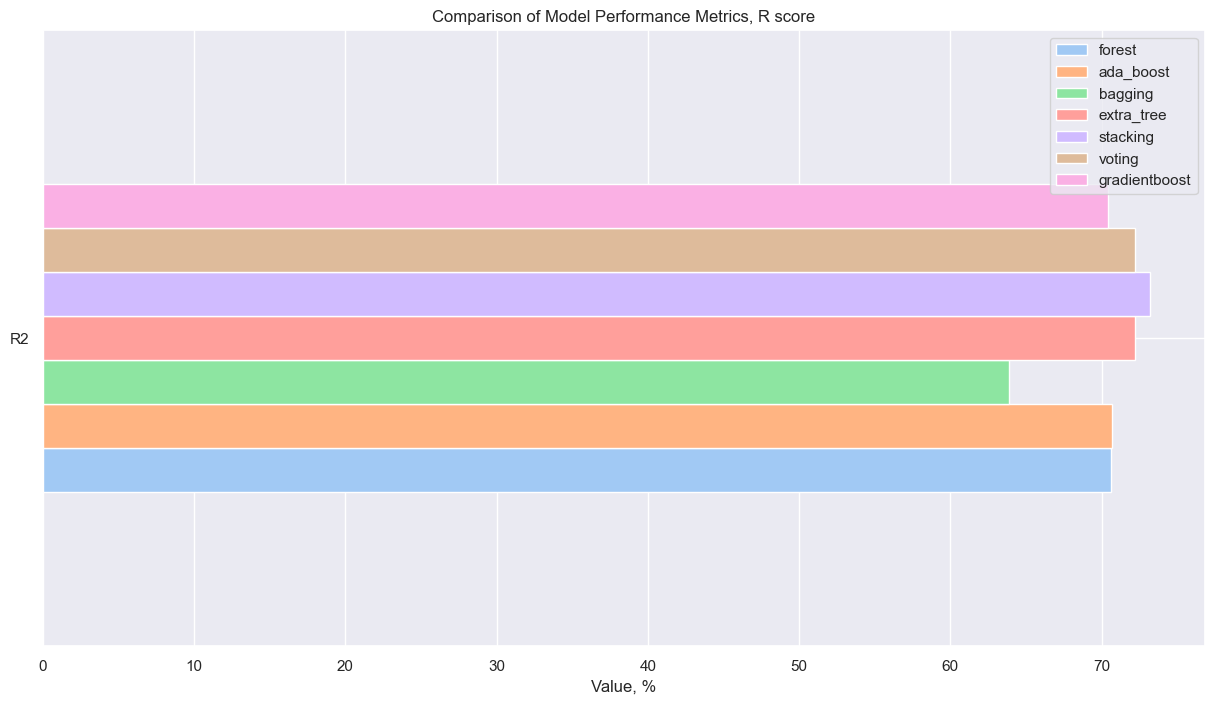

In [102]:
drow_compare_score(compare_ensamble)

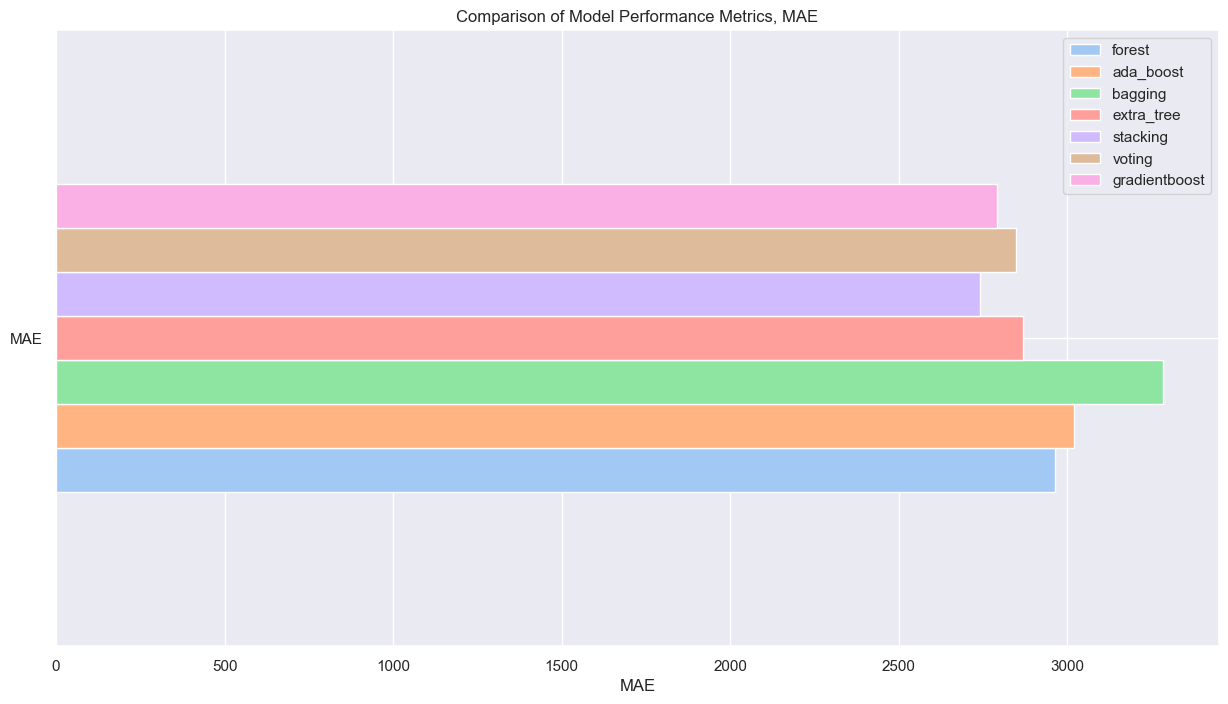

In [103]:
drow_compare_mae(compare_ensamble)

### *Based on the consolidated table of results and graph, we can say that the most accurate model for price forecasting is the Stacking model.*

#### *Save model*

In [106]:
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(st_reg, f)